# Model evaluation script was utilize to evaluate performance on test data.

### Inputs:
    #Final trained model to be evaluated (Created in ML_Pipeline_part4).
    #Encoded data in the form of a pickle file (created in ML_Pipeline_part1,ML_Pipeline_part2,ML_Pipeline_part3

In [4]:
#This cell imports libraries necessary for the model.

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
import pickle
import numpy as np
import math
import warnings
from decimal import Decimal, ROUND_DOWN


from sklearn.model_selection import GridSearchCV, train_test_split,ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNet,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF,WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor, ExtraTreesRegressor,BaggingRegressor
from mlxtend.regressor import StackingRegressor,StackingCVRegressor
import xgboost as xgb

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, validation_curve,GridSearchCV,learning_curve,cross_val_score,KFold

from collections import defaultdict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr, linregress

In [5]:
# R squared function.
def rsquared(y_true, y_pred):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = linregress(y_true, y_pred)
    return r_value**2

#mean absolute percent error.
def MAPE(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) /y_true)) *100

In [6]:
# plotting serperate individual values
def example_plot(ax,name2,group2,title2):
        temp1= np.max([group['actual'].max(),group['prediction'].max()])
        pr = pearsonr(group['prediction'],group['actual'])

        text = '\nMAE: '+str(Decimal(str(mae(group['prediction'],group['actual']))).quantize(Decimal('.01')))+'\nR: '+str(Decimal(str(pr[0])).quantize(Decimal('0.01')))#+'\nMSE:'+str(Decimal(str(mse(group['prediction'],group['actual']))).quantize(Decimal('0.001')))
        text = '\nMAE: '+str(Decimal(str(mae(group['prediction'],group['actual']))).quantize(Decimal('.01')))+'\nR2: '+str(Decimal(str(rsquared(group['prediction'],group['actual']))).quantize(Decimal('0.01')))#+'\nMSE:'+str(Decimal(str(mse(group['prediction'],group['actual']))).quantize(Decimal('0.001')))
        if temp1 < 1:
            temp1+=.05
            lineData = np.arange(0,temp1,.01)
        elif temp1 <75:
            temp1+=1.5
            lineData = np.arange(0,temp1)
        else:
            temp1+=3
            lineData = np.arange(0,temp1)
        ax.plot(lineData,lineData,color='red')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(name2,fontsize=18)
        ax.text(0.2,0.9,text,horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,fontsize=15)
        ax.plot(group2['actual'],group2['prediction'], marker='.',linestyle='',ms=12)
        ax.set_ylabel('Prediction (g/L)',size=15)
        ax.set_xlabel('Experimental (g/L)',size=15)


### Ensure that the encoded data & final pickle model to be evaluated or used for predictions are in the correct directory.

In [12]:
with open ('TESTData_part3.pickle','rb') as f:
    encodedData = pickle.load(f)    

    
with open('M21iYL.pickle','rb') as f:
    masterGrid = pickle.load(f)   
    
    
masterGrid = masterGrid[0]    

In [13]:
# Used features in the final model.
cols_train__set = [
'mw_Lipids'
,'pH'
,'product_deltaGo'
,'foldCarbonFed'
,'product_name'
,'rxt_volume'
,'inputThermo(kJ/L)'
,'FermentationTime'
,'atp_cost'
,'precursorsRequiredEncoded'
,'nadh_nadph_cost'
,'Pathway_enzymatic_steps'
,'averageThermBarrier'
,'media'
,'number_genes_het'
,'number_native_genes_overexp'
,'ATP_iYLI647'
,'NADPH_iYLI647'
,'PPP_iYLI647'
,'TCA_iYLI647'
,'PrdtYield_iYLI647'
    
,'Product_titer(g/L)'
,'Product_rate(g/L/h)'
,'Product_yield(g/gC)'
]


target_cols_todrop = [
'Product_yield(g/gC)'
,'Product_rate(g/L/h)'
,'Product_titer(g/L)'
]

In [14]:
prdt_class = np.arange(1,10)
product_superclass = ['Organic acid', 'Lipid','Small terpene','Large terpene','Flavonoid','Fatty acid-derived','Alcohol','Glycan','Polyketide']
productsToTestCases = ['a-Ionone', 'Mevalonate', 'Campersterol', 'a-Farnesene', '1-decanol','Arachidonic acid']

productDict = dict(zip(prdt_class,product_superclass))


scaledData = pd.DataFrame()
scaledData = encodedData[0]


# scaledData = pd.concat([scaledTESTData,scaledData])
heldOutTest = pd.DataFrame()

temp = []
for p in productsToTestCases:
    temp = scaledData[scaledData.product_name2 == p]
    tempIndex = scaledData[scaledData.product_name2 ==p].index
    heldOutTest = heldOutTest.append(temp)

useful_cols = []
useful_cols.extend(cols_train__set)

data = scaledData.loc[:,useful_cols]

for column in data:
    data[column] = data[column].astype(np.float32)



In [15]:
#uncomment following line to test validate, training split. For test data, comment line.
# train, test = train_test_split(data, test_size = 0.20, random_state = 566,stratify=data['product_name'])

test = data #comment out if want to use validate, training data, generated in line above
train = data #comment out if want to use validate, training data, generated in line above
x_train = train.copy()
x_test = test.copy()
y_test = test.copy()

toCont = ['product_name']


for target1 in target_cols_todrop:
    x_train.drop(target1,axis=1,inplace=True)
    x_test.drop(target1,axis=1,inplace=True)
x_testData = x_test.copy()
target = 'Product_titer(g/L)'


In [16]:
y_prediction = np.exp(masterGrid[target].predict(x_testData))
y_actual = y_test[target]
pr = pearsonr(y_prediction,y_actual)

print('For ' + target)
print('***************************************')
print('r2:\n',rsquared(y_prediction,y_actual),'\nMAE:\n',mae(y_prediction,y_actual),'\nMSE\n',mse(y_prediction,y_actual),'\nPearson R\n',pearsonr(y_prediction,y_actual),'\nMAPE\n',MAPE(y_actual,y_prediction))

For Product_titer(g/L)
***************************************
r2:
 0.8882798308339088 
MAE:
 2.4386030483458137 
MSE
 44.11033246713216 
Pearson R
 (0.9424859844230632, 2.0235993014e-314) 
MAPE
 145.73136462623043


In [17]:
#figure save name
save_name = 'M21iYL_1200.eps'


### Following cell generates a figure with the line of fit.

For Product_titer(g/L)
***************************************
r2:
 0.8882798308339088 
MAE:
 2.4386030483458137 
MSE
 44.11033246713216 
Pearson R
 (0.9424859844230632, 2.0235993014e-314)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


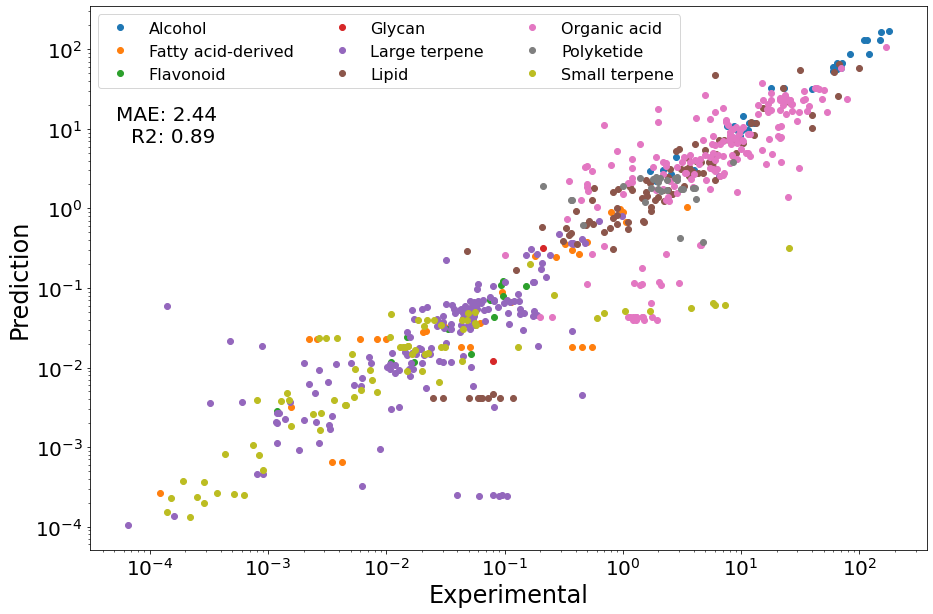

In [18]:
target_cols = [
'Product_titer(g/L)'
]

title = 'Total Set'
i=0
for target in target_cols:
    
    y_prediction = np.exp(masterGrid[target].predict(x_testData))
    y_actual = y_test[target]
    print('For ' + target)
    print('***************************************')
    # print("Test set score: {:.2f}".format(masterGrid[target].score(x_testData, y_actual)))
    pr = pearsonr(y_prediction,y_actual)

    print('r2:\n',rsquared(y_prediction,y_actual),'\nMAE:\n',mae(y_prediction,y_actual),'\nMSE\n',mse(y_prediction,y_actual),'\nPearson R\n',pearsonr(y_prediction,y_actual))
    # print('pearson:',pearsonr(y_prediction,y_actual),'MAE:',mae(y_prediction,y_actual))

    text = '\nMAE: '+str(Decimal(str(mae(y_prediction,y_actual))).quantize(Decimal('.01')))+'  \nR: '+str(Decimal(str(pr[0])).quantize(Decimal('0.01')))#+'\nMSE:'+str(Decimal(str(mse(y_prediction,y_actual))).quantize(Decimal('0.00001')))
    text = '\nMAE: '+str(Decimal(str(mae(y_prediction,y_actual))).quantize(Decimal('.01')))+'  \nR2: '+str(Decimal(str(rsquared(y_prediction,y_actual))).quantize(Decimal('0.01')))
    # i+=1
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    ax.margins(0.05)
    y_hat=pd.DataFrame()

    y_hat['prediction']=y_prediction
    y_hat.index=y_actual.index
    y_hat['actual']=y_actual
    y_hat['productClass']=x_testData['product_name']
    y_hat['superClass']=x_testData['product_name'].map(productDict)

    temp1= max(np.max(y_actual),np.max(y_prediction))
    # temp1= np.max([group['actual'].max(),group['prediction'].max()])

    lineData = np.arange(0,temp1)
    groups = y_hat.groupby('superClass')
    for name, group in groups:
        #print(group)
        # print(name)
        ax.plot(group['actual'],group['prediction'], marker='.',linestyle='',ms=12,label=name)

    ax.legend(loc=2,ncol=3,fontsize=16)
    #ax.scatter(y_prediction,y_actual,c=label,cmap=matplotlib.colors.ListedColormap(colors))
    #ax.scatter(y_prediction,y_actual,c='black')

    # line = mlines.Line2D([0, 1], [0, 1], color='red')
    ax.text(0.1,0.8,text,horizontalalignment='center',verticalalignment='center',transform=ax.transAxes,fontsize=20)
    # line.set_transform(transform)
    # ax.add_line(line)
    ax.set_ylabel('Prediction',size=24)
    ax.set_xlabel('Experimental',size=24)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # low,high = plt.xlim()
    # l2,h2 = plt.ylim()
    # ax.set_xlim(min(low,l2),max(high,h2))
    # ax.set_ylim(min(low,l2),max(high,h2))
    # ax.plot(lineData,lineData,color='red')

    #anchored_text = AnchoredText(text, loc=3)
    #ax.add_artist(anchored_text)
    # plt.savefig('model_iYali4_p2a_heldOUT.png')
    plt.savefig(save_name,format='eps',dpi=1200,bbox_inches='tight')
    i+=1

### Following cell generates a 3 x 3 grid of figures for each product class.

For Product_titer(g/L)
***************************************
R:
 0.8882798308339088 
MAE:
 2.4386030483458137 
MSE
 44.11033246713216 
PearsonR: (0.9424859844230632, 2.0235993014e-314)


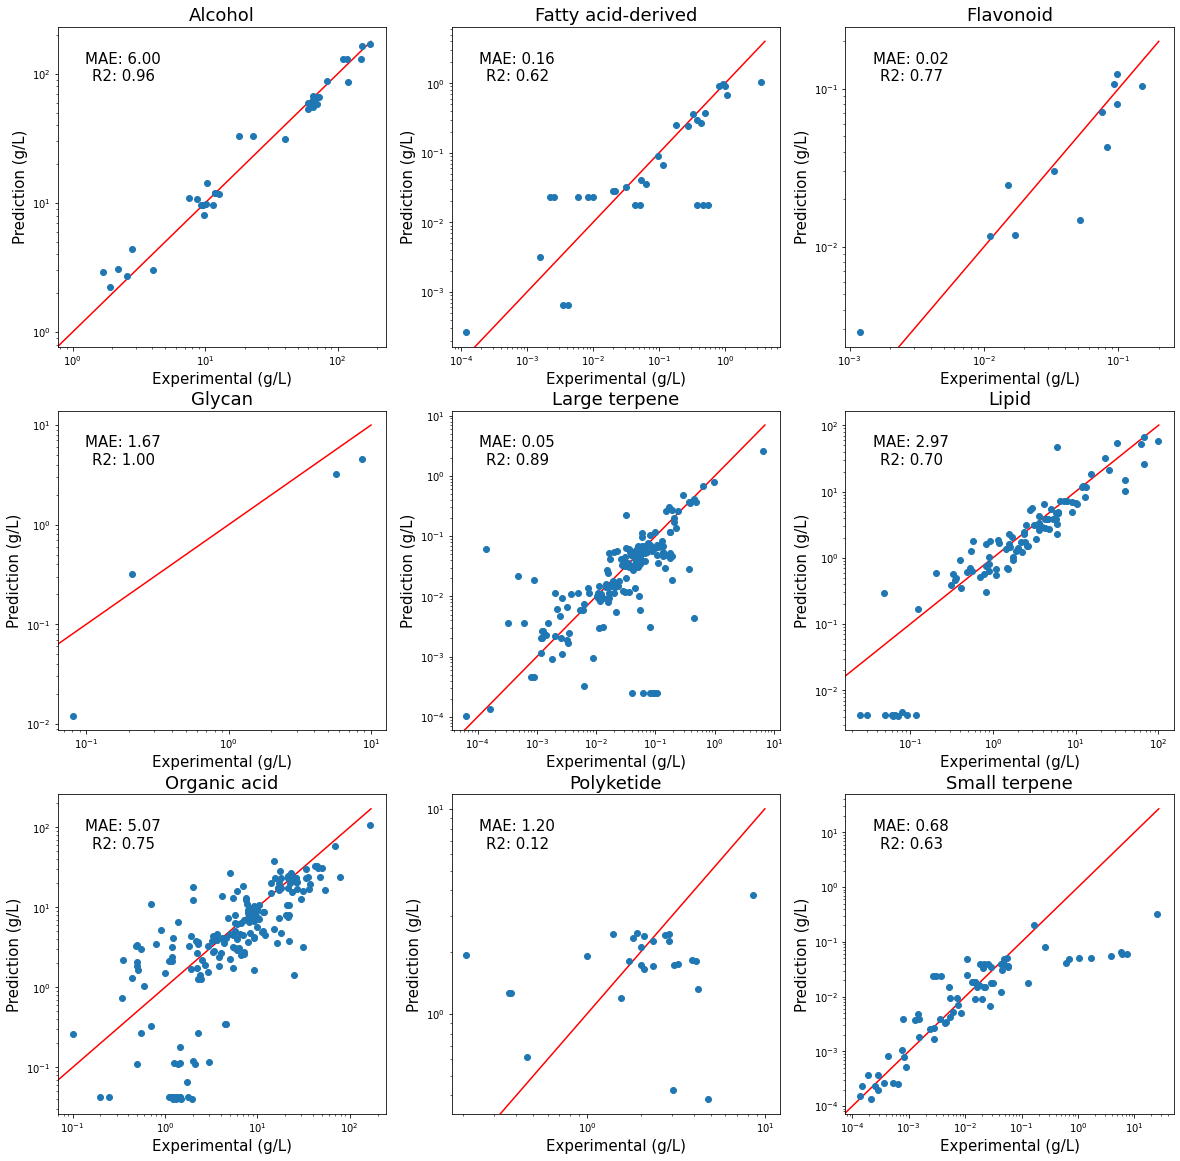

In [19]:
x_testData = x_test.copy()
i=0
for target in target_cols:
    y_prediction = np.exp(masterGrid[target].predict(x_testData))
    y_actual = y_test[target]
    print('For ' + target)
    print('***************************************')
    # print("Test set score: {:.2f}".format(masterGrid[target].score(x_testData, y_actual)))
    pr = pearsonr(y_prediction,y_actual)
    print('R:\n',rsquared(y_prediction,y_actual),'\nMAE:\n',mae(y_prediction,y_actual),'\nMSE\n',mse(y_prediction,y_actual),'\nPearsonR:',pr)
    # print('pearson:',pearsonr(y_prediction,y_actual),'MAE:',mae(y_prediction,y_actual))



    y_hat=pd.DataFrame()
    y_hat['prediction']=y_prediction
    y_hat.index=y_actual.index
    y_hat['actual']=y_actual
    y_hat['productClass']=x_testData['product_name']
    y_hat['superClass']=x_testData['product_name'].map(productDict)
    groups = y_hat.groupby('superClass')
    k=1
    fig, axes = plt.subplots(3,3,figsize=(20,20))
    # plt.suptitle('Model FFA, Validation Data')
    axes2 = axes.flatten()
    for name, group in groups:
        example_plot(axes2[k-1],name,group,title)
        k+=1
    plt.savefig('3by3'+save_name,format='eps',dpi=1200,bbox_inches='tight')


